# Stanford Cars - Benchmark Model

This notebook has the benchmark model for my Stanford Cars predictions.

#### TL;DR
- Accuracy of **84.95%** on the test set (96.31% Top5 Accuracy)
- Did not use the image annotations in this benchmark
- Used the standard Fastai v1 image transforms
- Used `lr_find()` to find the optimal learning rate and `fit_one_cycle` for training
- Unfroze the model for additional tuning
- Resized the images from 224 -> 299 
- Used Test Time Augmentation (TTA) for testing

This and the following notebooks are all thanks to fastai's AMAZING course and library, checkout https://fast.ai for the course and libray, you won't regret it!

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
import matplotlib.pyplot as plt

import scipy.io as sio

In [2]:
from fastai import *
from fastai.vision import *

## Getting the Data

In [3]:
path = 'data/stanford-cars/'

In [4]:
!pwd

/home/paperspace/mmg_ml/projects


In [5]:
PATH = Path(path)
list(PATH.iterdir())

[PosixPath('data/stanford-cars/car_devkit.tgz'),
 PosixPath('data/stanford-cars/cars_test_annos_withlabels.mat'),
 PosixPath('data/stanford-cars/.ipynb_checkpoints'),
 PosixPath('data/stanford-cars/test'),
 PosixPath('data/stanford-cars/merged'),
 PosixPath('data/stanford-cars/labels_annos.csv'),
 PosixPath('data/stanford-cars/anno.csv'),
 PosixPath('data/stanford-cars/labels_with_annos.csv'),
 PosixPath('data/stanford-cars/train_labels.csv'),
 PosixPath('data/stanford-cars/models'),
 PosixPath('data/stanford-cars/devkit'),
 PosixPath('data/stanford-cars/train'),
 PosixPath('data/stanford-cars/cars_annos.mat')]

Rename the Train and Test folders:

In [6]:
# !mv /home/paperspace/mmg_ml/projects/data/stanford-cars/cars_train /home/paperspace/mmg_ml/projects/data/stanford-cars/train
# !mv /home/paperspace/mmg_ml/projects/data/stanford-cars/cars_test /home/paperspace/mmg_ml/projects/data/stanford-cars/test

Perform some one-off data manipulations to get all the files and filenames in an easy to use format

In [7]:
# !mkdir merged
# !cp -a test/. merged    # copy all test files to a merged folder
# !cd merged
# !rename 's/^/test_/' *  # add 'test_' to the start of every filename in the current directory
# !cd ..
# !cp -a train/. merged   # copy all train files to the merged folder

In [ ]:
# p = path + 'train/'
# fns = []
# for i in range(0, len(labels_df.loc[labels_df['is_test'] == 0])):
#     fn = 'cropped_'+labels_df['filename'][i]
#     plt.imsave(path +'/merged/' + fn, crop(labels_df,p, i))
#     fns.append(fn)
    
# for i in range(0, len(labels_df.loc[labels_df['is_test'] == 1])):
#     fns.append('not_cropped')
    
# labels_df['filename_cropped'] = fns

The file data is stored in .mat files, making it a little awkward to retrieve the necessary data such as class IDs, class names and annotations. The below cell is modified Devon Yates' code on Kaggle, thanks Devon! 
https://www.kaggle.com/criticalmassacre/inaccurate-labels-in-stanford-cars-data-set

In [4]:
# Need to host CSV somewhere

train_annos_path = 'devkit/cars_train_annos.mat'
test_annos_path = 'cars_test_annos_withlabels.mat'
classes_path = 'devkit/cars_meta.mat'

def get_labels(annos_path, classes_path):
    car_annos = sio.loadmat(path + annos_path)
    car_meta = sio.loadmat(path + classes_path)
    annotations = car_annos["annotations"][0,:]
    nclasses = len(car_meta["class_names"][0])
    class_names = dict(zip(range(1,nclasses),[c[0] for c in car_meta["class_names"][0]]))
    
    labelled_images = {}
    dataset = []
    for i,arr in enumerate(annotations):
        # the last entry in the row is the image name
        # The rest is the data, first bbox, then classid
        dataset.append([y[0][0] for y in arr][0:5]+[arr[5][0]])
    # Convert to a DataFrame, and specify the column names
    temp_df = pd.DataFrame(dataset, 
                      columns =['BBOX_X1','BBOX_Y1','BBOX_X2','BBOX_Y2','ClassID','filename'])

    temp_df = temp_df.assign(ClassName=temp_df.ClassID.map(dict(class_names)))
    temp_df.columns = ['bbox_x1','bbox_y1','bbox_x2','bbox_y2','class_id','filename', 'class_name']
    return temp_df

Create the `labels_df` which contains all the file info we need to get started

In [5]:
train_df = get_labels(train_annos_path, classes_path)
train_df['is_test'] = 0
train_df.to_csv(path + 'train_labels.csv', index=False)

test_df = get_labels(test_annos_path, classes_path)
test_df['is_test'] = 1

# Add missing class name! - 'smart fortwo Convertible 2012'
train_df.loc[train_df['class_name'].isnull(), 'class_name'] = 'smart fortwo Convertible 2012'
test_df.loc[test_df['class_name'].isnull(), 'class_name'] = 'smart fortwo Convertible 2012'

frames = [train_df, test_df]
labels_df = pd.concat(frames)
labels_df.reset_index(inplace=True, drop=True)
labels_df = labels_df[['filename', 'bbox_x1', 'bbox_y1','bbox_x2','bbox_y2',
                            'class_id', 'class_name','is_test']]

# adjust the test file names
labels_df['filename'].loc[labels_df['is_test']==1] = 'test_' + labels_df['filename']

# Add the cropped file names
labels_df['filename_cropped'] = labels_df['filename'].copy()
labels_df['filename_cropped'].loc[labels_df['is_test']==0] = 'cropped_' + labels_df['filename']

labels_df.to_csv(path + 'labels_with_annos.csv')
labels_df.head()

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


filename  bbox_x1  bbox_y1  bbox_x2  bbox_y2  class_id  \
0  00001.jpg       39      116      569      375        14   
1  00002.jpg       36      116      868      587         3   
2  00003.jpg       85      109      601      381        91   
3  00004.jpg      621      393     1484     1096       134   
4  00005.jpg       14       36      133       99       106   

                            class_name  is_test   filename_cropped  
0                  Audi TTS Coupe 2012        0  cropped_00001.jpg  
1                  Acura TL Sedan 2012        0  cropped_00002.jpg  
2           Dodge Dakota Club Cab 2007        0  cropped_00003.jpg  
3     Hyundai Sonata Hybrid Sedan 2012        0  cropped_00004.jpg  
4  Ford F-450 Super Duty Crew Cab 2012        0  cropped_00005.jpg

In [6]:
labels_df['class_name'].nunique(), labels_df['class_id'].nunique() 

(196, 196)

Add xy, height and width of the bounding box

bb_fastai is of the format **hw_bb**

In [11]:
#labels_df['bb_xy'] = tuple(labels_df[col] for col in ['bbox_x1','bbox_y1'])
labels_df['bbox_h'] = (labels_df['bbox_y2'] - labels_df['bbox_y1']) + 1
labels_df['bbox_w'] = (labels_df['bbox_x2'] - labels_df['bbox_x1']) + 1
labels_df.head()

filename  bbox_x1  bbox_y1  bbox_x2  bbox_y2  class_id  \
0  00001.jpg       39      116      569      375        14   
1  00002.jpg       36      116      868      587         3   
2  00003.jpg       85      109      601      381        91   
3  00004.jpg      621      393     1484     1096       134   
4  00005.jpg       14       36      133       99       106   

                            class_name  is_test   filename_cropped  bbox_h  \
0                  Audi TTS Coupe 2012        0  cropped_00001.jpg     260   
1                  Acura TL Sedan 2012        0  cropped_00002.jpg     472   
2           Dodge Dakota Club Cab 2007        0  cropped_00003.jpg     273   
3     Hyundai Sonata Hybrid Sedan 2012        0  cropped_00004.jpg     704   
4  Ford F-450 Super Duty Crew Cab 2012        0  cropped_00005.jpg      64   

   bbox_w  
0     531  
1     833  
2     517  
3     864  
4     120

Define lists for the bounding boxes, in case we need them in future

In [12]:
bb_hw = labels_df[['bbox_x1', 'bbox_y1','bbox_h', 'bbox_w']].values
hw_bb = labels_df[['bbox_h', 'bbox_w', 'bbox_x1', 'bbox_y1']].values
bb_hw

array([[ 39, 116, 260, 531],
       [ 36, 116, 472, 833],
       [ 85, 109, 273, 517],
       [621, 393, 704, 864],
       ...,
       [ 23,  18, 442, 618],
       [ 33,  27, 226, 570],
       [ 33, 142, 235, 489],
       [ 77,  73, 308, 430]], dtype=int64)

Lets look closer at the data, how many class_ids do we have? Does it match the number of class names?

In [13]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

# White text on black outline
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_rect(ax, b):
#     patch = ax.add_patch(patches.Rectangle(xy, w,h, fill=False, edgecolor='white', lw=2))
    patch = ax.add_patch(patches.Rectangle(b[:2], b[3], b[2], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)
    
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

Define `compare_top_losses` and `compare_most_confused` for examining the model results later

In [14]:
def compare_top_losses(k, interp, labels_df, num_imgs):
    tl_val,tl_idx = interp.top_losses(k)
    classes = interp.data.classes
    probs = interp.probs
    columns = 2
    rows = 2
    
    topl_idx = 0   
    for i,idx in enumerate(tl_idx):
        fig=plt.figure(figsize=(10, 8))
        columns = 2
        rows = 1
        
        # Actual Image
        act_im, cl = interp.data.valid_ds[idx]
        cl = int(cl)        
        act_cl = classes[cl]
        act_fn = labels_df.loc[labels_df['class_name'] == act_cl]['filename'].values[0]
        
        # Predicted Image
        pred_cl = interp.pred_class[idx]
        pred_cl = classes[pred_cl]
        pred_fn = labels_df.loc[labels_df['class_name'] == pred_cl]['filename'].values[0]
        
        print(f'PREDICTION:{pred_cl}, ACTUAL:{act_cl}')
        print(f'Loss: {tl_val[i]:.2f}, Probability: {probs[i][cl]:.4f}')
              
        # Add image to the left column
        img_path = 'train/' + pred_fn
        im = plt.imread(path+img_path)
        fig.add_subplot(rows, columns, 1)
        plt.imshow(im)
        
        # Add image to the right column, need to change the tensor shape (permute) for matplotlib
        perm = act_im.data.permute(1,2,0)
        fig.add_subplot(rows, columns, 2)
        plt.imshow(perm)

        plt.show()

In [15]:
def compare_most_confused(most_confused, labels_df, num_imgs, rank):
    c1 = most_confused[:][rank][0]
    c2 = most_confused[:][rank][1]
    n_confused = most_confused[:3][0][1]
    print(most_confused[:][rank])
      
    # set the list of 
    f_1 = labels_df.loc[labels_df['class_name'] == c1]['filename'].values
    f_2 = labels_df.loc[labels_df['class_name'] == c2]['filename'].values

    fig=plt.figure(figsize=(10, 8))
    columns = 2
    rows = num_imgs
    for i in range(1, columns*rows +1, 2):
        # Add image to the left column
        img_path = 'train/' + f_1[i]
        im = plt.imread(path+img_path)
        fig.add_subplot(rows, columns, i)
        plt.imshow(im)
        
        # Add image to the right column
        img_path = 'train/' + f_2[i]
        im = plt.imread(path+img_path)
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(im)

    plt.show()

Lets have a quick look at what the image with bounding box looks like:

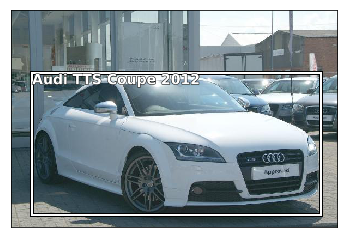

In [16]:
img_path = 'train/' + labels_df['filename'][0]

im = plt.imread(path+img_path)
idx = 0
b = bb_hw[idx]

c = labels_df['class_name'].values[idx]

ax = show_img(im)
draw_rect(ax, b)
draw_text(ax, b[:2], c, sz=14)

Lets define a crop function to crop the image based on the annotations given

In [ ]:
def crop(df, path, i):
    image = plt.imread(path + df['filename'][i])
    x1 = df['bbox_x1'][i]
    y1 = df['bbox_y1'][i]
    h = df['bbox_h'][i]
    w = df['bbox_w'][i]
    
    if len(image.shape) == 3:
        return image[y1:y1+h , x1:x1+w, :]
    else:
        # If there are only 2 channels for the image
        return image[y1:y1+h , x1:x1+w]

Crop the Training images...

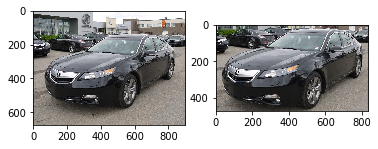

In [15]:
fig = plt.figure()
ax = fig.add_subplot(121)
p = path + 'train/'
ax.imshow(plt.imread(p + labels_df['filename'][1]))

ax1 = fig.add_subplot(122)
ax1.imshow(crop(labels_df,p, 1))

plt.show()

## Data Loading

Lets define what we want our transforms to be

In [11]:
help(get_transforms)

Help on function get_transforms in module fastai.vision.transform:

get_transforms(do_flip:bool=True, flip_vert:bool=False, max_rotate:float=10.0, max_zoom:float=1.1, max_lighting:float=0.2, max_warp:float=0.2, p_affine:float=0.75, p_lighting:float=0.75, xtra_tfms:Union[Collection[fastai.vision.image.Transform], NoneType]=None) -> Collection[fastai.vision.image.Transform]
    Utility func to easily create a list of flip, rotate, `zoom`, warp, lighting transforms.



In [7]:
SZ = 224
SEED = 42
LABEL = 'class_name'

car_tfms = get_transforms()

trn_labels_df = labels_df.loc[labels_df['is_test']==0, ['filename', 'class_name', 'class_id']].copy()

src = (ImageItemList.from_df(trn_labels_df, path, folder='train', cols='filename')
                    .random_split_by_pct(valid_pct=0.2, seed=SEED)
                    .label_from_df(cols=LABEL))

data = (src.transform(car_tfms, size=SZ)
            .databunch()
            .normalize(imagenet_stats))

Having a look at the images in our datablock you can see result of the image transforms:

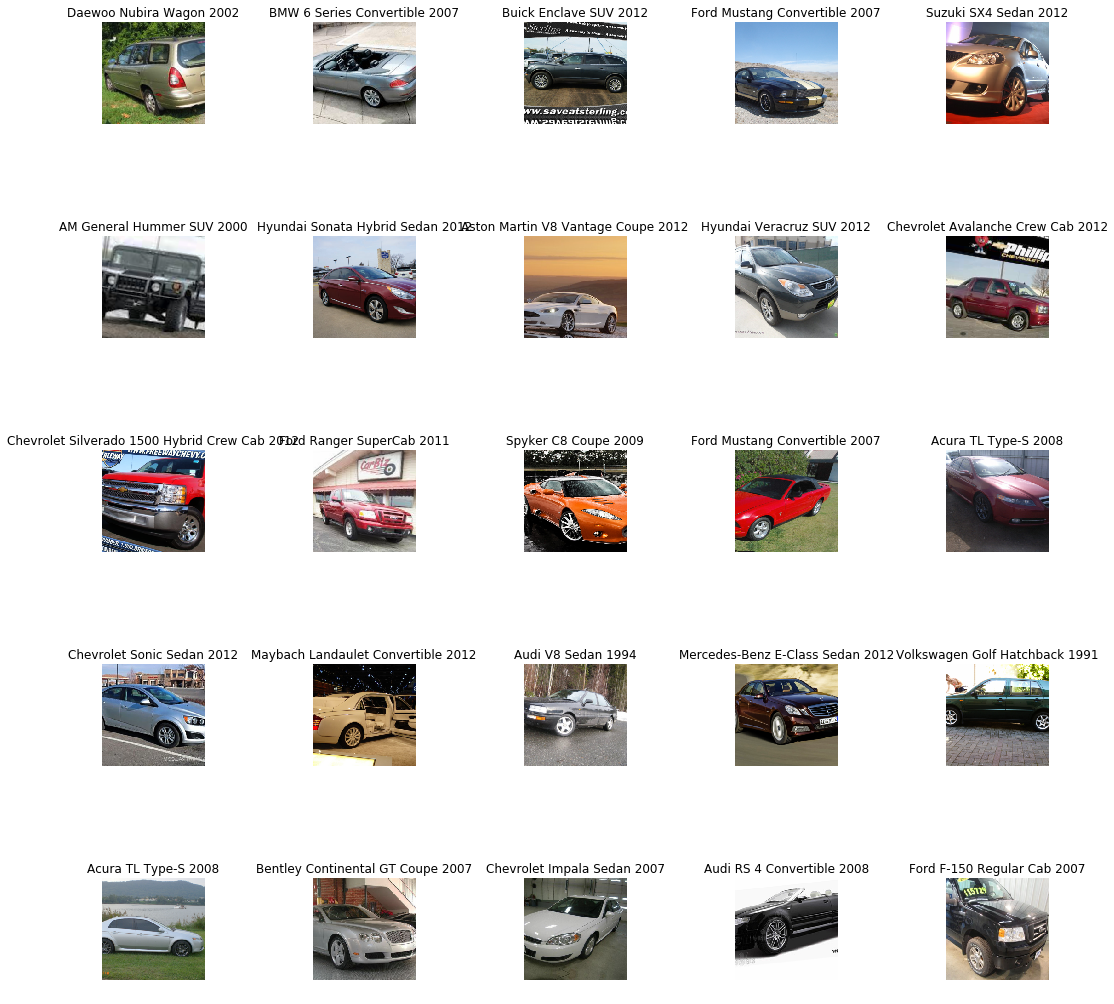

In [13]:
data.show_batch(rows=5, figsize=(15,15))

Loading an individual image to see how the `train_ds` property works

Audi TTS Coupe 2012


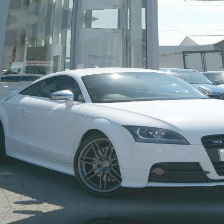

In [15]:
ds = data.train_ds

img,label = ds[0]
print(label)
img

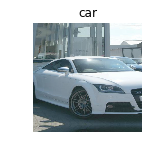

In [16]:
img.show(figsize=(2,2), title='car')

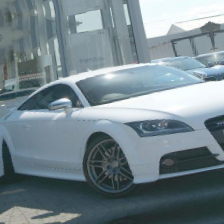

In [17]:
img.rotate(10)

## Lets Get Training

Define the model architecture and parameters we would like to use. Why ResNET152? Honestly just going by the philosophy that bigger is better! Comparing the performance of different ResNETs might be an interesting experiment for the future

In [8]:
arch = models.resnet152

Because we are using such a large model, and images of 224, I had to start with a batch size of 32 to avoid out of memory erros

In [9]:
data.batch_size = 32
data.batch_size

32

Use fastai's v1 `create_cnn` function to create a standard convolution NN learner

In [10]:
learn = create_cnn(data, arch, metrics=[accuracy])

Using `lr_find` a good starting point for the learning rate can be found

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


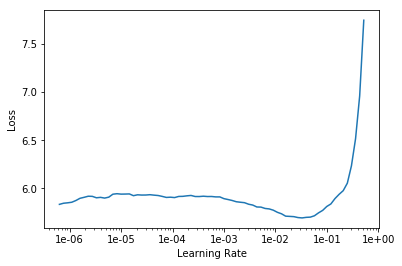

In [21]:
learn.lr_find()
learn.recorder.plot()

In [22]:
lr = 1e-2

I found that 14 epochs was a good place to stop as the model started to overfit while the accuracy didn't improve further

In [23]:
learn.fit_one_cycle(14, max_lr = lr)

In [29]:
learn.save('stage-1-rn152-bench')

In [11]:
learn.load('stage-1-rn152-bench')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (6516 items)
[Category Audi TTS Coupe 2012, Category Acura TL Sedan 2012, Category Dodge Dakota Club Cab 2007, Category Hyundai Sonata Hybrid Sedan 2012, Category Ford F-450 Super Duty Crew Cab 2012]...
Path: data/stanford-cars
x: ImageItemList (6516 items)
[Image (3, 400, 600), Image (3, 675, 900), Image (3, 480, 640), Image (3, 1386, 2100), Image (3, 108, 144)]...
Path: data/stanford-cars;

Valid: LabelList
y: CategoryList (1628 items)
[Category Plymouth Neon Coupe 1999, Category Honda Odyssey Minivan 2012, Category Aston Martin Virage Convertible 2012, Category Fisker Karma Sedan 2012, Category Audi S6 Sedan 2011]...
Path: data/stanford-cars
x: ImageItemList (1628 items)
[Image (3, 759, 1012), Image (3, 338, 600), Image (3, 418, 628), Image (3, 768, 1024), Image (3, 1575, 2100)]...
Path: data/stanford-cars;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding

Unfreezing all layers of the model will allow fine tuning of the earlier layers

In [13]:
learn.unfreeze()

Making the batch size smaller again as I encountered out of memory errors continuing with bs = 32

In [14]:
data.batch_size = 16
data.batch_size

16

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


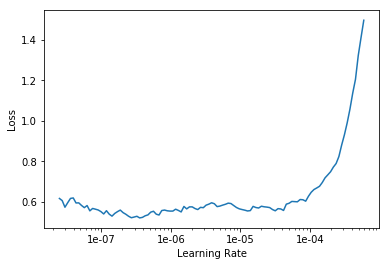

In [19]:
learn.lr_find(start_lr=1e-8, end_lr=9e-1, num_it=200)
learn.recorder.plot()

The optimal learning rate was much much smaller here, there probably aren't massive gains to be had from here

Using quite a small lr here, with differential learning rates

In [20]:
lr = 1e-7
lrs = np.array([lr/100,lr/10,lr])

The train and valid losses didn't really improve at this point using such a small lr

In [21]:
learn.fit_one_cycle(5, lrs)

In [24]:
learn.save('stage-2-rn152-bench')

#### Interestingly...
As small learning rate didn't have much of an impact, I checked out whether ignoring the `lr_find` suggestion and kept the lr relatively high at 1e-3. This seemed to provide a better result! I'll further investigate this in a later notebook, for now for this benchmark model I'll continue with the naive approach as per my initial approach

In [15]:
# Testing with higher LR and unfrozen layers
learn.load('stage-1-rn152-bench')
learn.unfreeze()
data.batch_size = 16

lr = 1e-3
lrs = np.array([lr/100,lr/10,lr])

learn.fit_one_cycle(6, lrs)

### Back to training...

In [21]:
#learn.load('stage-2-rn152')

Resize the dataset, freeze the earlier layers again and continue learning.

In [26]:
SZ = 299
SEED = 42
LABEL = 'class_name'

car_tfms = get_transforms()

data = (src.transform(car_tfms, size=SZ)
            .databunch()
            .normalize(imagenet_stats))

data.batch_size = 16

print(data.batch_size)
data.train_ds[0][0].shape

16


torch.Size([3, 299, 299])

Running out of memory with 256x256 images, halfing the batch size to 32

In [27]:
learn.data = data

In [28]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


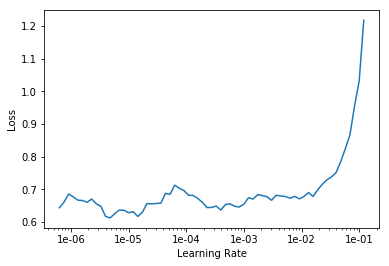

In [29]:
learn.lr_find()
learn.recorder.plot()

In [30]:
lr=3e-6

In [31]:
learn.fit_one_cycle(5, max_lr = slice(lr))

Neither the train or validation loss are really improving here, lets see if unfreezing and training all the layers will help

In [37]:
learn.save('stage-3-rn152-bench')

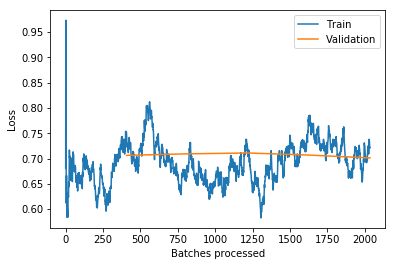

In [33]:
learn.recorder.plot_losses()

Again, unfreeze all layers and tune them...

In [38]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


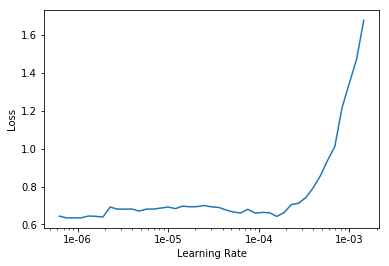

In [39]:
learn.lr_find()
learn.recorder.plot()

In [40]:
lr = 5e-5
lrs = np.array([lr/9,lr/3,lr])

In [41]:
learn.fit_one_cycle(3, lrs)

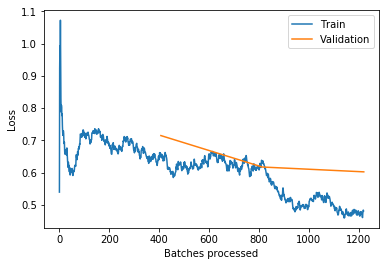

In [42]:
learn.recorder.plot_losses()

Model is starting to overfit here to lets finish here with our training, time to see some results!

In [ ]:
learn.freeze()

In [43]:
learn.save('stage-4-rn152-bench')

In [16]:
learn.load('stage-4-rn152-bench')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (6516 items)
[Category Audi TTS Coupe 2012, Category Acura TL Sedan 2012, Category Dodge Dakota Club Cab 2007, Category Hyundai Sonata Hybrid Sedan 2012, Category Ford F-450 Super Duty Crew Cab 2012]...
Path: data/stanford-cars
x: ImageItemList (6516 items)
[Image (3, 400, 600), Image (3, 675, 900), Image (3, 480, 640), Image (3, 1386, 2100), Image (3, 108, 144)]...
Path: data/stanford-cars;

Valid: LabelList
y: CategoryList (1628 items)
[Category Plymouth Neon Coupe 1999, Category Honda Odyssey Minivan 2012, Category Aston Martin Virage Convertible 2012, Category Fisker Karma Sedan 2012, Category Audi S6 Sedan 2011]...
Path: data/stanford-cars
x: ImageItemList (1628 items)
[Image (3, 759, 1012), Image (3, 338, 600), Image (3, 418, 628), Image (3, 768, 1024), Image (3, 1575, 2100)]...
Path: data/stanford-cars;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding

## Results

Lets interpret the performance, where did the model do poorly? The `plot_top_losses` method doesn't print nicely here as I have used the car model names instead of car ids. A couple of custom functions used below (`compare_most_confused` and `compare_top_losses` help us better see where the model was going wrong.

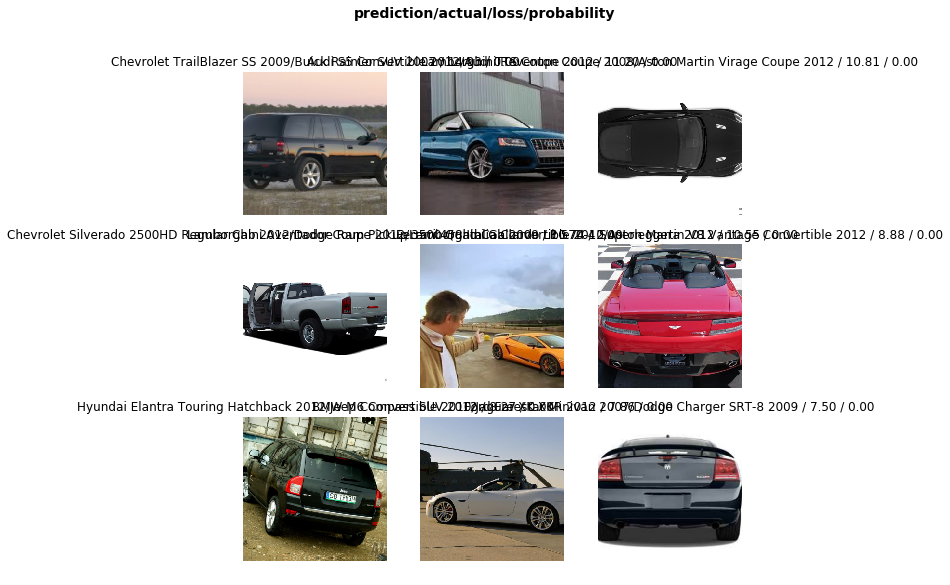

In [45]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(9,9))

Lets look at the most confused images. Visualising a number of samples from each of the confused classes can help see how our model is doing. Here we can see the model was getting confused between **very similar car models**, often just between different model years, if you're not into cars you would have to look closely to notice the differences!

I think it is super cool to see how the model confuses such similar car models. If we didn't care about the model year then aggregating the same car models of different years would likely give an even better accuracy score.

In [46]:
most_confused = interp.most_confused()

('Dodge Caliber Wagon 2007', 'Dodge Caliber Wagon 2012', 4)


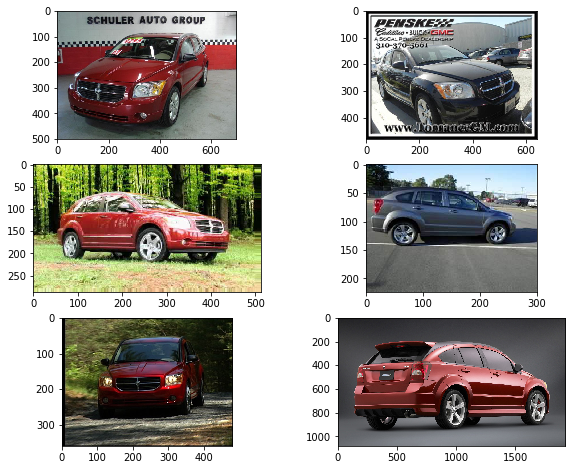

('HUMMER H2 SUT Crew Cab 2009', 'HUMMER H3T Crew Cab 2010', 4)


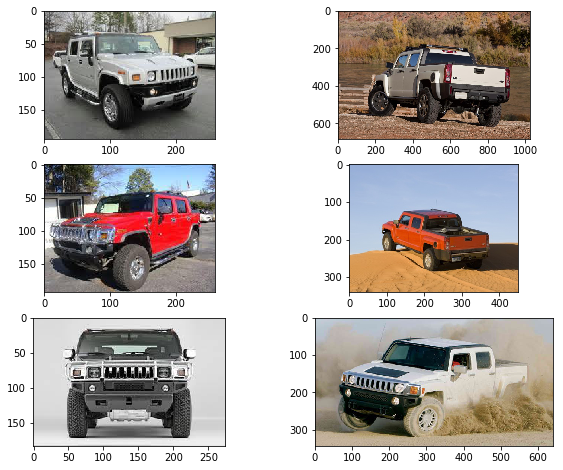

('Spyker C8 Convertible 2009', 'Spyker C8 Coupe 2009', 4)


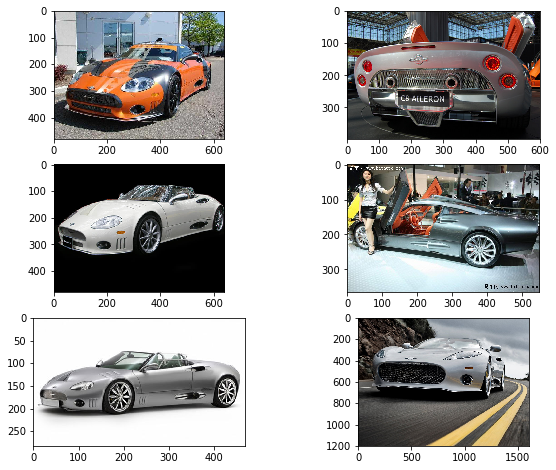

('Aston Martin V8 Vantage Convertible 2012', 'Aston Martin V8 Vantage Coupe 2012', 3)


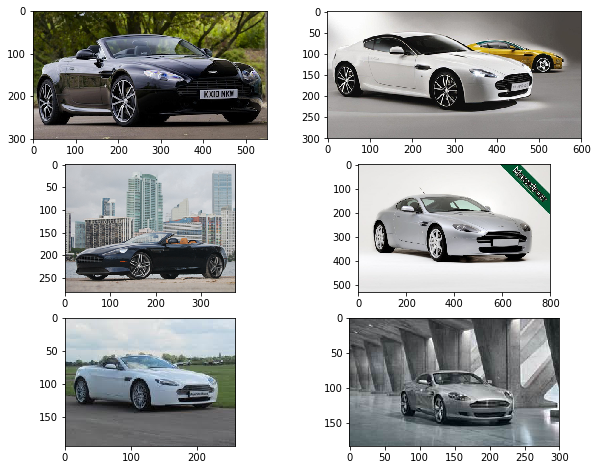

('Audi 100 Sedan 1994', 'Audi 100 Wagon 1994', 3)


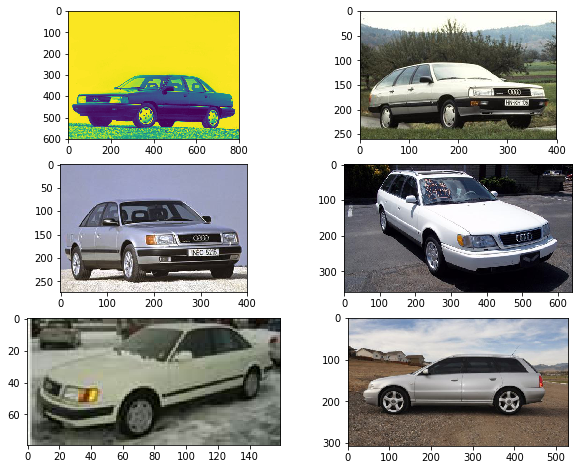

('Audi 100 Sedan 1994', 'Audi V8 Sedan 1994', 3)


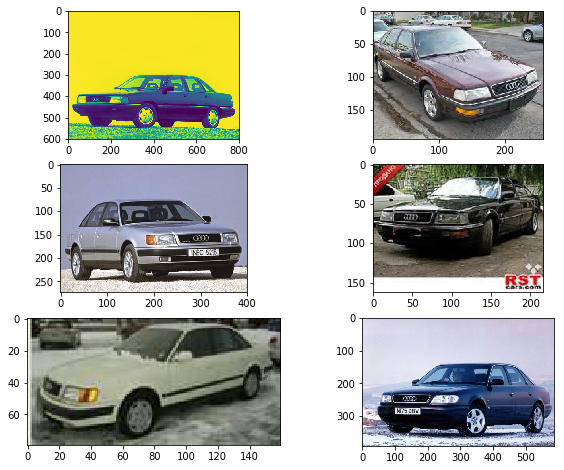

('Audi S4 Sedan 2012', 'Audi S5 Coupe 2012', 3)


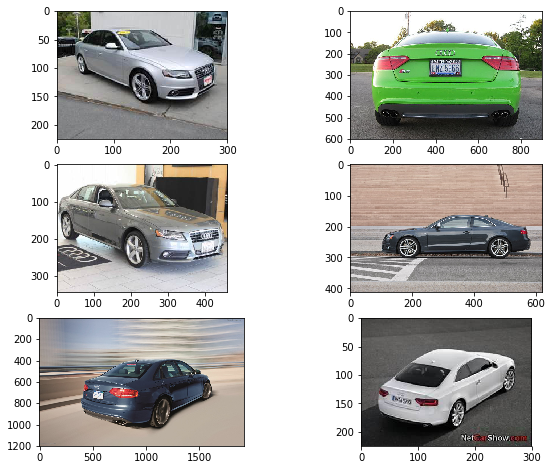

('BMW 6 Series Convertible 2007', 'BMW M6 Convertible 2010', 3)


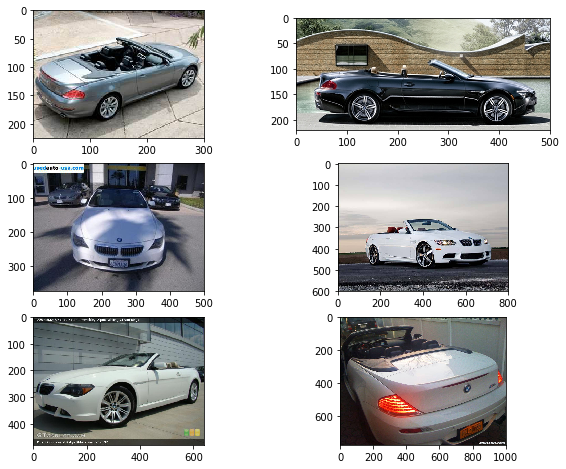

In [47]:
for i in range(0,8):
    compare_most_confused(most_confused=most_confused, labels_df=labels_df, 
                          num_imgs=3, rank=i)

Compare the classes with the top losses. Visualising the prediction-actual pairs can help understand where the model was getting it wrong

PREDICTION:Chevrolet TrailBlazer SS 2009, ACTUAL:Buick Rainier SUV 2007
Loss: 14.93, Probability: 0.0000


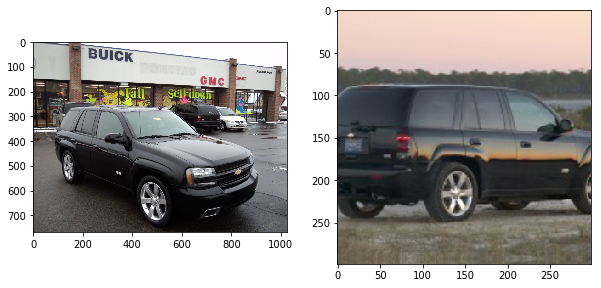

PREDICTION:Audi S5 Convertible 2012, ACTUAL:Audi TTS Coupe 2012
Loss: 11.20, Probability: 0.0000


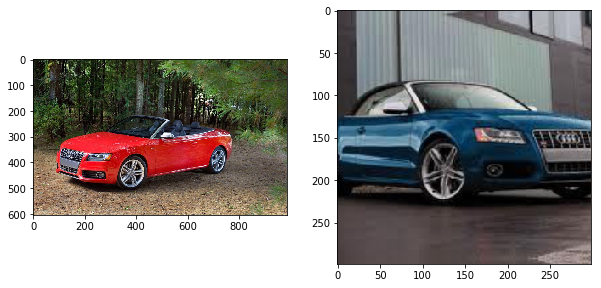

PREDICTION:Lamborghini Reventon Coupe 2008, ACTUAL:Aston Martin Virage Coupe 2012
Loss: 10.81, Probability: 0.0009


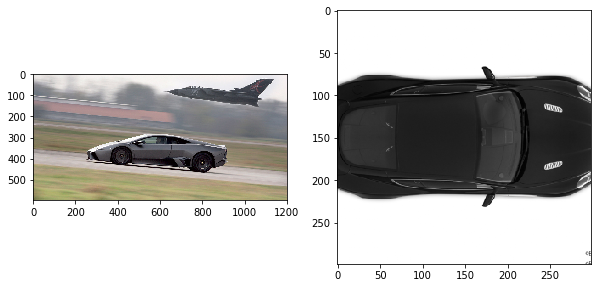

PREDICTION:Chevrolet Silverado 2500HD Regular Cab 2012, ACTUAL:Dodge Ram Pickup 3500 Quad Cab 2009
Loss: 10.74, Probability: 0.0000


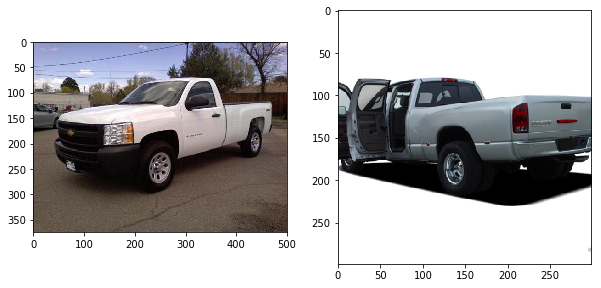

PREDICTION:Lamborghini Aventador Coupe 2012, ACTUAL:Lamborghini Gallardo LP 570-4 Superleggera 2012
Loss: 10.55, Probability: 0.0000


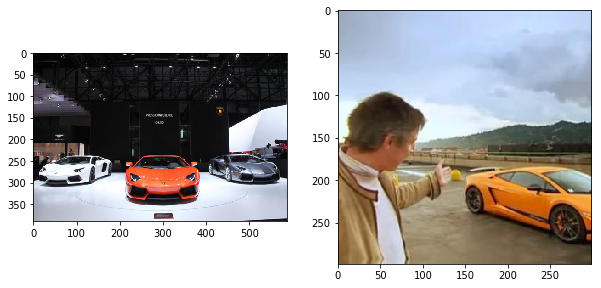

PREDICTION:Ferrari 458 Italia Convertible 2012, ACTUAL:Aston Martin V8 Vantage Convertible 2012
Loss: 8.88, Probability: 0.0000


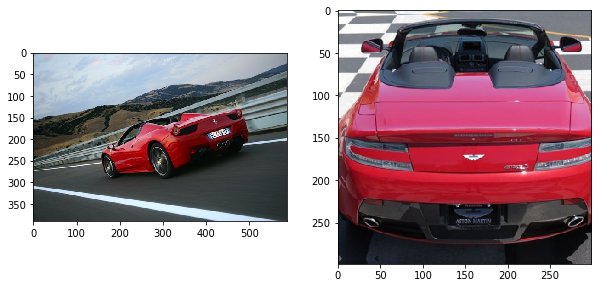

PREDICTION:Hyundai Elantra Touring Hatchback 2012, ACTUAL:Jeep Compass SUV 2012
Loss: 8.27, Probability: 0.0000


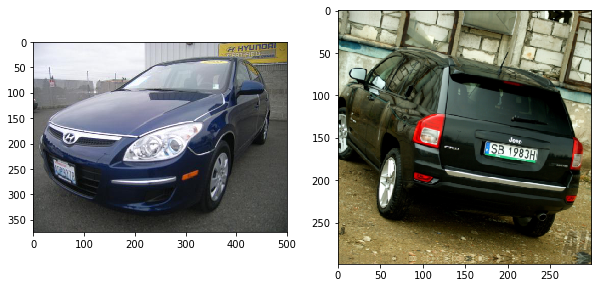

PREDICTION:BMW M6 Convertible 2010, ACTUAL:Jaguar XK XKR 2012
Loss: 7.86, Probability: 0.0000


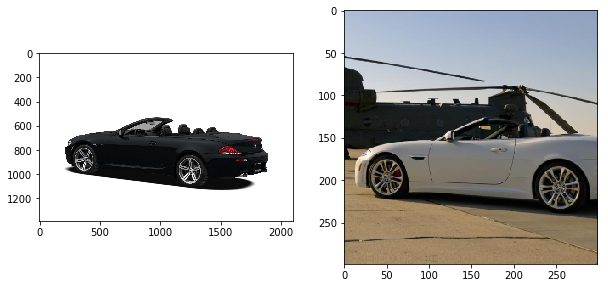

PREDICTION:Ford Freestar Minivan 2007, ACTUAL:Dodge Charger SRT-8 2009
Loss: 7.50, Probability: 0.0000


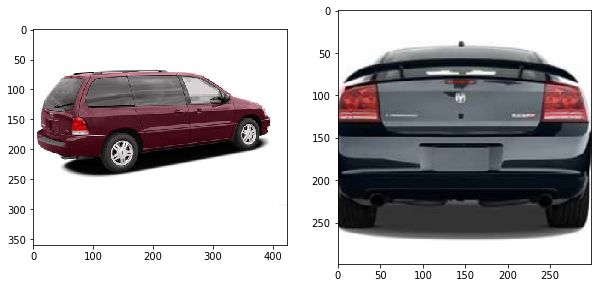

PREDICTION:Ram C/V Cargo Van Minivan 2012, ACTUAL:GMC Yukon Hybrid SUV 2012
Loss: 7.34, Probability: 0.0000


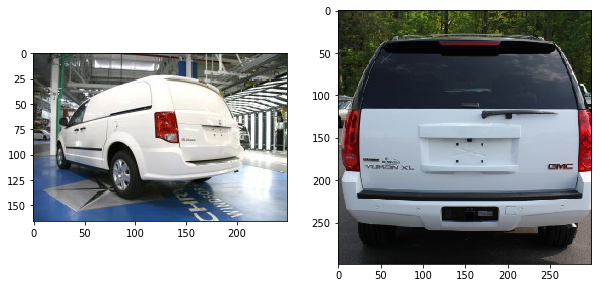

In [48]:
compare_top_losses(10, interp, labels_df, 1)

## Test Set Performance

Define the test dataset to check the acurracy on the test set

In [17]:
SZ = 299
SEED = 42
LABEL = 'class_name'

car_tfms = get_transforms()

src = (ImageItemList.from_df(labels_df, path, folder='merged', cols='filename')
       # the 'is_test' column has values of 1 for the test set
       .split_from_df(col='is_test')
       .label_from_df(cols=LABEL))

data_test = (src.transform(car_tfms, size=SZ)
            .databunch()
            .normalize(imagenet_stats))

Assign the full dataset to the Learner, the 'Validation set' here is actually our Test set

In [18]:
learn.data = data_test

Use Test Time Augmentation (TTA) for the predictions on the test set

In [111]:
test_preds, test_ys = learn.TTA()

In [112]:
accuracy(test_preds, test_ys)

tensor(0.8495)

This accuracy of **84.95%** will be the baseline to compare further iterations

Check Top5 Accuracy (mostly for ego-boosting purposes!)

In [119]:
def accuracy_topk(output, target, topk=(3,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

The Top5 Accuracy was an ego-reassuring **96.31%**

In [120]:
accuracy_topk(test_preds, test_ys, topk=(5,))

[tensor([96.3064])]